For this project you'll dig into a large amount of text and apply most of what you've covered in this unit and in the course so far.

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic or from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

This capstone can be an extension of your NLP challenge if you wish to use the same corpus. If you found problems with that data set that limited your analysis, however, it may be worth using what you learned to choose a new corpus. Reserve 25% of your corpus as a test set.

1. The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

2. Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. 

3. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

4. Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent? If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

In [102]:
import time
import pandas as pd
import numpy as np
import spacy
import nltk
from nltk.corpus import gutenberg
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from sklearn import neighbors
from sklearn.svm import SVC
from sklearn import tree
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit

import warnings 
warnings.simplefilter('ignore')

In [81]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [130]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
# Load and clean the data.
leaves = gutenberg.raw('whitman-leaves.txt')
paradise = gutenberg.raw('milton-paradise.txt')
blake = gutenberg.raw('blake-poems.txt')
hiawatha = open("The Song Of Hiawatha, by Henry W. Longfellow.txt")
hiawatha = hiawatha.read()
endymion = open("Endymion, by John Keats.txt")
endymion = endymion.read()
odyssey = open("The Odyssey by Homer.txt")
odyssey = odyssey.read()
burns = open("The Complete Works of Robert Burns.txt")
burns = burns.read()
sea = open("Sea Garden by Hilda Doolittle.txt")
sea = sea.read()
beowulf = open("Beowulf by Leslie Hall.txt")
beowulf = beowulf.read()
sappho = open("Sappho- One Hundred Lyrics by Bliss Carman.txt")
sappho = sappho.read()


# unique cleaning
paradise = re.sub(r'Book \D{1,3}', '', paradise)
endymion = re.sub(r'BOOK \D{1,3}', '', endymion)
odyssey = re.sub(r'BOOK \D{1,3}', '', odyssey)
odyssey = re.sub(r'ARGUMENT', '', odyssey)
blake = re.sub(r"[A-Z]+\b","",blake)
blake = re.sub(r"and   of","",blake)
beowulf = re.sub(r"^[A-Z]+\.","",beowulf)
sea = re.sub(r"^[A-Z]+","",sea)
burns = re.sub(r"^[A-Z]+", "",burns)
burns = re.sub(r"^[A-Z]+\.", "",burns)

#books = [paradise, blake, leaves, hiawatha, endymion]
#for b in books:
    #books = text_cleaner(b[:int(len(b)/30)])
s = 20
paradise = text_cleaner(paradise[:int(len(paradise)/s)])
blake = text_cleaner(blake[:int(len(blake)/s)])
leaves = text_cleaner(leaves[:int(len(leaves)/s)])
hiawatha = text_cleaner(hiawatha[:int(len(hiawatha)/s)])
endymion = text_cleaner(endymion[:int(len(endymion)/s)])
odyssey = text_cleaner(odyssey[:int(len(odyssey)/s)])
burns = text_cleaner(burns[:int(len(burns)/s)])
sea = text_cleaner(sea[:int(len(sea)/s)])
beowulf = text_cleaner(beowulf[:int(len(beowulf)/s)])
sappho = text_cleaner(sappho[:int(len(sappho)/s)])

print(paradise[:100])
print(blake[:100])
print(leaves[:100])
print(hiawatha[:100])
print(endymion[:100])
print(odyssey[:100])
print(burns[:100])
print(sea[:100])
print(beowulf[:100])
print(sappho[:100])

Of Man's first disobedience, and the fruit Of that forbidden tree whose mortal taste Brought death i
Piping down the valleys wild, Piping songs of pleasant glee, On a cloud saw a child, And he laughing
Come, said my soul, Such verses for my Body let us write, (for we are one,) That should I after retu
Should you ask me, whence these stories? Whence these legends and traditions, With the odors of the 
A thing of beauty is a joy for ever: Its loveliness increases; it will never Pass into nothingness; 
In a council of the Gods, Minerva calls their attention to Ulysses, still a wanderer. They resolve t
. WINTER. A DIRGE. The wintry west extends his blast, And hail and rain does blaw; Or the stormy nor
ROSE Rose, harsh rose, marred and with stint of petals, meagre flower, thin, sparse of leaf, more pr
THE LIFE AND DEATH OF SCYLD. {The famous race of Spear-Danes.} Lo! the Spear-Danes' glory through sp
I Cyprus, Paphos, or Panormus May detain thee with their splendour Of oblations on thine al

In [131]:
# Parse the cleaned novels. This can take a bit.
nlp = spacy.load('en')
paradise_doc = nlp(paradise)
blake_doc = nlp(blake)
leaves_doc = nlp(leaves)
hiawatha_doc = nlp(hiawatha)
endymion_doc = nlp(endymion)
odyssey_doc = nlp(odyssey)
burns_doc = nlp(burns)
sea_doc = nlp(sea)
beowulf_doc = nlp(beowulf)
sappho_doc = nlp(sappho)

print('done!')

done!


In [139]:
# Group into sentences.
paradise_sents = [[sent, "Milton"] for sent in paradise_doc.sents]
blake_sents = [[sent, "Blake"] for sent in blake_doc.sents]
leaves_sents = [[sent, "Whitman"] for sent in leaves_doc.sents]
hiawatha_sents = [[sent, "Longfellow"] for sent in hiawatha_doc.sents]
endymion_sents = [[sent, "Keats"] for sent in endymion_doc.sents]
odyssey_sents = [[sent, "Homer"] for sent in odyssey_doc.sents]
burns_sents = [[sent, "Burns"] for sent in burns_doc.sents]
sea_sents = [[sent, "Doolittle"] for sent in sea_doc.sents]
beowulf_sents = [[sent, "Beowulf"] for sent in beowulf_doc.sents]
sappho_sents = [[sent, "Sappho"] for sent in sappho_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(paradise_sents + blake_sents + 
                         leaves_sents + hiawatha_sents + 
                         endymion_sents + odyssey_sents +
                         burns_sents + sea_sents +
                         beowulf_sents + sappho_sents)
sentences.head()

,0,1
0,"(Of, Man, 's, first, disobedience, ,, and, the...",Milton
1,"(And, chiefly, thou, ,, O, Spirit, ,, that, do...",Milton
2,"(Say, first, for, Heaven, hides, nothing, from...",Milton
3,"(Who, first, seduced, them, to, that, foul, re...",Milton
4,"(Th, ', infernal, Serpent, ;, he, it, was, who...",Milton


In [142]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(3000)]

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 50 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
blakewords = bag_of_words(blake_doc)
paradisewords = bag_of_words(paradise_doc)
leaveswords = bag_of_words(leaves_doc)
hiawathawords = bag_of_words(hiawatha_doc)
endymionwords = bag_of_words(endymion_doc)
odysseywords = bag_of_words(odyssey_doc)
burnswords = bag_of_words(burns_doc)
seawords = bag_of_words(sea_doc)
beowulfwords = bag_of_words(beowulf_doc)
sapphowords = bag_of_words(sappho_doc)

# Combine bags to create a set of unique words.
common_words = set(blakewords + paradisewords + 
                   leaveswords + hiawathawords + 
                   endymionwords + odysseywords +
                   burnswords + seawords +
                   beowulfwords +sapphowords)

In [143]:
# Create our data frame with features. This can take a while to run.
start_time = time.time()
print('Processing...')

word_counts = bow_features(sentences, common_words)

t= round((time.time() - start_time),4)
print("\n -- %s seconds --\n" % t)

word_counts.head()

Processing...
Processing row 0
Processing row 50
Processing row 100
Processing row 150
Processing row 200
Processing row 250
Processing row 300
Processing row 350
Processing row 400
Processing row 450
Processing row 500
Processing row 550
Processing row 600
Processing row 650
Processing row 700
Processing row 750
Processing row 800
Processing row 850
Processing row 900
Processing row 950
Processing row 1000
Processing row 1050
Processing row 1100
Processing row 1150
Processing row 1200
Processing row 1250
Processing row 1300
Processing row 1350
Processing row 1400
Processing row 1450
Processing row 1500
Processing row 1550
Processing row 1600
Processing row 1650
Processing row 1700
Processing row 1750
Processing row 1800
Processing row 1850
Processing row 1900
Processing row 1950
Processing row 2000
Processing row 2050
Processing row 2100
Processing row 2150

 -- 44320.9745 seconds --



,diet,cease,unrestricted,afflict,knapsack,sh,woefu,swim,real,bubble,...,v.,sanctuary,substance,may,theme,offering,ammiral,clover,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Of, Man, 's, first, disobedience, ,, and, the...",Milton
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(And, chiefly, thou, ,, O, Spirit, ,, that, do...",Milton
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Say, first, for, Heaven, hides, nothing, from...",Milton
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Who, first, seduced, them, to, that, foul, re...",Milton
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Th, ', infernal, Serpent, ;, he, it, was, who...",Milton


In [ ]:
#increase common words
#explore td=idf

In [144]:
# Define the features and the outcome.
y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))



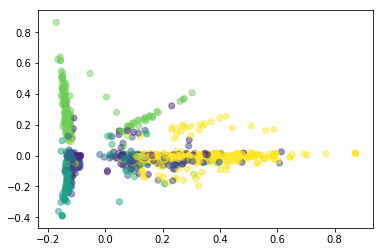

Comparing k-means clusters against the data:
text_source  Beowulf  Blake  Burns  Doolittle  Homer  Keats  Longfellow  \
row_0                                                                     
0                  0      0      3          0      0      0           0   
1                  3      6     79          0     26      8          11   
2                  1      0     90          0      1      1           0   
3                 68      7    428          6    152     23          26   
4                  2      3      2          0     29      1           0   
5                  0      1     76          0     19      2           1   
6                  6      0     60          0     24      6           4   
7                 25      3     73          1     32      3           5   
8                  0      0     52          0      7      0           2   
9                 13      0    209          4     82     11           7   

text_source  Milton  Sappho  Whitman  
row_0          

In [145]:
start_time = time.time()

# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(int(X_norm.shape[0]/2)).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=10, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, alpha = 0.5)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

print("--- %s seconds for model fit ---" % (time.time() - start_time))

In [89]:
X_norm.shape

(463, 3040)

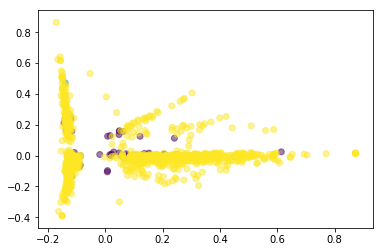

Comparing k-means clusters against the data:
text_source  Beowulf  Blake  Burns  Doolittle  Homer  Keats  Longfellow  \
row_0                                                                     
0                  3      0     16          0      9      1           2   
1                  3      0      3          0      9      0           1   
2                  1      0    125          0      6      0           1   
3                 60      8    413          6    173     22          24   
4                 13      0    220          4     81     12           7   
5                 24      3     63          1     29      3           4   
6                  1      2     24          0     20      4           5   
7                  0      0     57          0      0      2           1   
8                 11      1     73          0     19      2           1   
9                  2      6     78          0     26      9          10   

text_source  Milton  Sappho  Whitman  
row_0          

In [147]:
#plot true values
start_time = time.time()

# Normalize the data.
X_norm = normalize(X)

#pca = PCA(2).fit(X_norm)
# Reduce it to two components.
X_pca = PCA(int(X_norm.shape[0]/2)).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=10, random_state=42).fit_predict(X_pca)

labels = y.map(lambda x: 0 if x == "Milton" else (1 if x == "Blake" else 2))
# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, alpha = 0.5)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

print("--- %s seconds to model ---" % (time.time() - start_time))

In [148]:
start_time = time.time()

# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=10,
    batch_size=200)
minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))

print("--- %s seconds to model ---" % (time.time() - start_time))

Comparing k-means and mini batch k-means solutions:
col_0   0  1   2    3    4    5   6   7    8    9
row_0                                            
0       0  3  10   47   12    1   2   2    2    0
1       1  1   5    0    0  131   1   0    3    0
2      13  0  30   35    5    1   1   4    0    1
3       1  0   0    0    1    2  34   0    0    0
4       0  7  13    3  402    7   1   3    0    0
5       3  4   3    1    0    8   0   0    4  154
6      20  9  62  778    1    4  43  57    3    1
7       0  2   1    0    0    0   0   1  113    0
8       0  1  10   39   17    7   3   6    0    2
9       3  1   2   22    4    1   0   0    5    6
--- 0.258256196975708 seconds to model ---


In [ ]:
#pca(reduce by half then only plot first 2) or lsa

In [155]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.25,
                                                    stratify = y,
                                                    random_state=0)

split = StratifiedShuffleSplit(n_splits=5, random_state=1337)

In [156]:
y_test.value_counts()

Burns         268
Homer          93
Whitman        79
Milton         32
Beowulf        29
Keats          14
Longfellow     14
Sappho         10
Blake           5
Doolittle       3
Name: text_source, dtype: int64

In [157]:
# Spot Check Algorithms
models = []
models.append(('NBB', BernoulliNB()))
models.append(('RFC', ensemble.RandomForestClassifier()))
models.append(('KNN', neighbors.KNeighborsClassifier()))
models.append(('DTC', tree.DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('SVC', SVC()))
models.append(('GBC', ensemble.GradientBoostingClassifier()))
models.append(('ABC', ensemble.AdaBoostClassifier()))
models.append(('ETC', ensemble.ExtraTreesClassifier()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
#models.append(('GMM', GaussianMixture()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    split = StratifiedShuffleSplit(n_splits=10, random_state=1337)
    model = model.fit(X_train,y_train)
    cv_results = cross_val_score(model, X_test, y_test, cv=split, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

NBB: 0.492727 (0.005455)
RFC: 0.576364 (0.039038)
KNN: 0.496364 (0.020000)
DTC: 0.585455 (0.042872)
GNB: 0.572727 (0.049627)
SVC: 0.490909 (0.000000)
GBC: 0.607273 (0.033722)
ABC: 0.489091 (0.005455)
ETC: 0.609091 (0.042446)
QDA: 0.096364 (0.032575)


In [93]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

split = StratifiedShuffleSplit(n_splits=5, random_state=1337)

score = cross_val_score(rfc, X_test, y_test, cv=split, scoring='accuracy')
print("\nCross Validation:\n    %0.2f (+/- %0.2f)" % (score.mean(), score.std()))
print(score)

Training set score: 0.9942363112391931

Test set score: 0.7672413793103449

Cross Validation:
    0.65 (+/- 0.11)
[0.66666667 0.66666667 0.58333333 0.5        0.83333333]


In [94]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2') # No need to specify l2 as it's the default. But we put it for demonstration.
lr.fit(X_train, y_train)

print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

split = StratifiedShuffleSplit(n_splits=5, random_state=1337)

score = cross_val_score(lr, X_test, y_test, cv=split, scoring='accuracy')
print("\nCross Validation:\n    %0.2f (+/- %0.2f)" % (score.mean(), score.std()))
print(score)

Training set score: 0.9798270893371758

Test set score: 0.8103448275862069

Cross Validation:
    0.72 (+/- 0.08)
[0.75       0.75       0.66666667 0.58333333 0.83333333]


In [95]:
clf = ensemble.GradientBoostingClassifier()
clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))


split = StratifiedShuffleSplit(n_splits=5, random_state=1337)

score = cross_val_score(clf, X_test, y_test, cv=split, scoring='accuracy')
print("\nCross Validation:\n    %0.2f (+/- %0.2f)" % (score.mean(), score.std()))
print(score)

Training set score: 0.9971181556195965

Test set score: 0.7586206896551724

Cross Validation:
    0.70 (+/- 0.11)
[0.66666667 0.66666667 0.66666667 0.58333333 0.91666667]
